# Imports

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset
import torch.nn as nn
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from models import LeNet5Variant
from models import MyConNet1
from models import MyConNet2
from models import MyConNet3
from models import MyConNet4
from trainer import MyTrainer

# Checks for CUDA

In [2]:
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)

if torch.cuda.is_available():
    device = torch.device('cuda')
print(device)

True
True
cuda


# Data prep

#### Loads the data

In [3]:
train_path = "./data/raw/train.csv"
test_path = "./data/raw/test.csv"

In [4]:
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

#### Formats data

In [5]:
# Separates labels
x = df_train.drop(labels="label", axis=1)
y = df_train["label"]

#### Data overview

In [6]:
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
df_train.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


#### Reshapes

In [8]:
# Convert to numpy arrays
x = x.to_numpy()
y = y.to_numpy()
test_npa = df_test.to_numpy()

In [9]:
# Updates shape to match image size 28x28x1 (only one channel per image)
x = x.reshape(-1, 1, 28, 28)
test_npa = test_npa.reshape(-1, 1, 28, 28)

In [10]:
# Divides the train set to train and validation
X_train, X_dev, y_train, y_dev = train_test_split(x, y, test_size=0.2, random_state=8888)

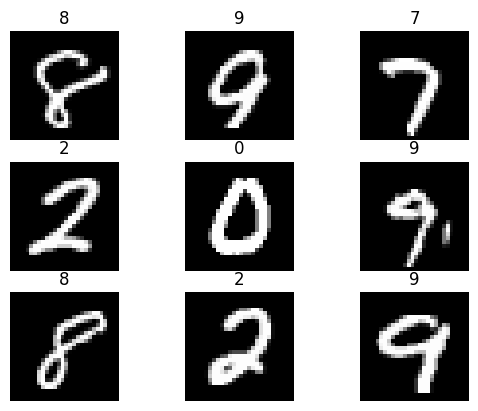

In [11]:
#train samples
for i in range(0, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(X_train[i].squeeze(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.title(y_train[i])

#### Converts images to tensors and normalize them

In [12]:
#train
X_train_tensor = torch.tensor(X_train)/255.0
y_train_tensor = torch.tensor(y_train)
train_tensor = TensorDataset(X_train_tensor, y_train_tensor)

#val
X_dev_tensor = torch.tensor(X_dev)/255.0
y_dev_tensor = torch.tensor(y_dev)
dev_tensor = TensorDataset(X_dev_tensor, y_dev_tensor)

#test
test_image_tensor = torch.tensor(test_npa)/255.0

#### Defines data loaders

In [13]:
train_loader = DataLoader(train_tensor, batch_size=16, num_workers=2, shuffle=True)
dev_loader = DataLoader(dev_tensor, batch_size=16, num_workers=2, shuffle=True)
test_loader = DataLoader(test_image_tensor, batch_size=16, num_workers=2, shuffle=False)

# Train the model

#### Define mode, loss and optimizer

In [25]:
model = MyConNet1()
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0005, momentum=0.95)
trainer = MyTrainer(model, optimizer, loss_function)

#### Fits the model to data

In [ ]:
trainer.fit(train_loader, dev_loader, epochs=50, eval_every=2)

# Make predictions on the test set

In [16]:
def make_predictions(data_loader):
    model.eval()
    test_preds = torch.LongTensor()

    for i, data in enumerate(data_loader):
        #data = data.unsqueeze(1)

        #if torch.cuda.is_available():
        #    data = data.cuda()

        output = model(data)

        preds = torch.max(output, dim=1)[1] #output.cpu().data.max(1, keepdim=True)[1]
        test_preds = torch.cat((test_preds, preds), dim=0)

    return test_preds

In [17]:
test_set_preds = make_predictions(test_loader)

In [18]:
submission_df = pd.read_csv("./input/sample_submission.csv")

In [19]:
submission_df['Label'] = test_set_preds.numpy().squeeze()
submission_df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,7
4,5,3


In [20]:
submission_df.to_csv('submission.csv', index=False)